In [349]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

Test for my full code

Interpolation using Bezier:

In [350]:
def cubic_bezier(P0, P1, P2, P3):  # Input -> the 4 points needed for every spline
    """
    :return: Given the 4 points needed for Bezier's curve, this function will take care of
    their multiplication so that the result will be a function of t ->
    once we have the curve for every set of 4 points, this function will return the interpolation
    value once given a t value.
    """

    # Let P0 and P3 be 2 points returning from f(xi)
    # Let P1 and P2 be 2 anchor points
    M = np.array(
        [[-1, +3, -3, +1],
         [+3, -6, +3, 0],
         [-3, +3, 0, 0],
         [+1, 0, 0, 0]],
        dtype=np.float64)  # Pascal's binomial matrix for cubic bezier
    P = np.array([P0, P1, P2, P3], dtype=np.float64)  # Array of the 4 points

    # B(t) = P0(1-t)^3 + 3*P1*t*(1-t)^2 + 3*P2*(t^2)*(1-t) + P3*(t^3)
    def f(t):
        T = np.array([np.power(t, 3), np.power(t, 2), t, 1], dtype=np.float64)
        return T.dot(M).dot(P)  # T x M x P

    return f

In [351]:
def MulThomas(a, b, c, d):  # Code taken from GitHub - Cbellei (username)
    '''
    An efficient algorithm for Solving linear equations in the form of A x X = B -> extracting X vector
    :param a: an array - part of tridiagonal matrix A
    :param b: an array - part of tridiagonal matrix A
    :param c: an array - part of tridiagonal matrix A
    :param d: an array - B array
    :return: Results array (vector) -> X array
    '''

    nf = len(d)
    ac, bc, cc, dc = map(np.array, [a, b, c, d])
    for it in range(1, nf):
        mc = ac[it - 1] / bc[it - 1]
        bc[it] = bc[it] - mc * cc[it - 1]
        dc[it] = dc[it] - mc * dc[it - 1]

    xc = bc
    xc[-1] = dc[-1] / bc[-1]

    for il in range(nf - 2, -1, -1):
        xc[il] = (dc[il] - cc[il] * xc[il + 1]) / bc[il]

    return xc

In [352]:
def interpolate_v1(f: callable, a: float, b: float, n: int) -> callable:
    """
    Returns
    -------
    The interpolating function.
    """
    Cubic_Bezier = lambda p1, p2, p3, p4: cubic_bezier(p1, p2, p3, p4)  # Inner call for productivity
    if n == 1:  # In case we can only use 1 point -> return a straight line
        f = lambda x: f((a + b) / 2)
        return f
    # Next we will create 2 arrays: X values and f(X) values
    x_values = np.linspace(a, b, n)  # Split the range to n - points
    y_values = [f(x) for x in x_values]  # Get the f(x) values
    points = np.array(list(zip(x_values, y_values)))  # Create n points in the form of (x,y)
    splines = n - 1  # Number of splines in the interpolation
    '''
    # Build the coefficient matrix (W) to create the linear system
    W = np.identity(splines)  # Create Identity matrix
    np.fill_diagonal(W, 4)  # Replace main diagonal with 4's
    np.fill_diagonal(W[1:], 1)
    np.fill_diagonal(W[:, 1:], 1)
    W[0, 0] = 2
    W[splines - 1, splines - 1] = 7
    W[splines - 1, splines - 2] = 2
    # Extract the 3 relevant diagonals from the matrix:
    a = np.diag(W, k=-1)
    b = np.diag(W, k=0)
    c = np.diag(W, k=1)
    '''
    # Build the coefficient matrix (W) to create the linear system
    c = [1.0] * (splines - 1)
    b = [4.0] * splines
    b[0] = 2.0
    b[len(b)-1] = 7.0
    a = [1] * (splines - 1)
    a[len(a)-1] = 2.0


    # build points vector (K)
    K = [2 * (2 * points[i] + points[i + 1]) for i in range(splines)]  # 4Ki + 2K_i+1
    K[0] = points[0] + 2 * points[1]  # K0 + 2*K1
    K[splines - 1] = 8 * points[splines - 1] + points[splines]  # 8*K_n-1 + K_n
    # for every point in points array get the x,y values separately
    dx = [x[0] for x in K]
    dy = [y[1] for y in K]

    # Multiply the matrix getting the X points and Y points
    # Getting the Values of the first anchor - A
    X = MulThomas(a, b, c, dx)
    Y = MulThomas(a, b, c, dy)

    # Update the A and B values Using the known mathematical equations
    # taking care of the A and B that way takes care of smoothing the curves
    A = np.array(list(zip(X, Y)))
    B = [0] * splines
    for i in range(splines - 1):
        B[i] = 2 * points[i + 1] - A[i + 1]
    B[splines - 1] = (A[splines - 1] + points[splines]) / 2

    # Create dictionaries for functions and x_values
    B3 = {}
    x_values = {}
    for i in range(splines):
        Ci = (points[i], A[i], B[i], points[i + 1])  # The 4 points for every spline
        # The interpolation for section [xi,x_i+1]
        # Returns a function f(t) for this spline, storing it in B3
        B3[(Ci[0][0], Ci[3][0])] = Cubic_Bezier(Ci[0], Ci[1], Ci[2], Ci[3])
        # x_values holds the x values of the 4 points constructing the spline i
        x_values[(Ci[0][0], Ci[3][0])] = (Ci[0][0], Ci[1][0], Ci[2][0], Ci[3][0])

    # Create a function that returns an interpolation function -> for x returns f(x)
    def interpolatz_PLATZ(x):
        for i in B3:  # Find the spline (function) that x answers to
            if i[0] < x < i[1]:
                X = x_values[i]
                t = (x - X[0]) / (X[3] - X[0])  # Get the relevant t from the x value
                y = B3[i](t)[1]  # Returned object is a point thus extract y-value
                return y

    # This line will hold the interpolation function as a returned parameter f(x_given) = y_value
    return interpolatz_PLATZ


In [353]:
minimum = -200.0
maximum = 200.0
Original_func = lambda x: x**3 - x**4
interpolation_func = interpolate_v1(Original_func, minimum -1, maximum + 1, 400)


In [354]:
def Check_interpolation(Original_func,interpolation_func,minimum,maximum, number_of_samples = 200):

  # Define the range of x values over which you want to plot the functions
  x_values = [random.uniform(minimum, maximum) for _ in range(number_of_samples)] # random
  x_values.remove(0) if 0 in x_values else None
  x_values = sorted(x_values)
  # Evaluate the first function over the range of x values
  y1 = [Original_func(x) for x in x_values]

  # Evaluate the second function over the range of x values
  y2 = [interpolation_func(x) for x in x_values]

  #Calaulate the error:
  def RMSE(y1,y2):
    errors = []
    for i in range(len(y1)):
      errors.append((y1[i] - y2[i])**2)
    return math.sqrt(sum(errors) / len(errors))
  print(RMSE(y1,y2))

  # Create a figure and axes object using Matplotlib
  fig, ax = plt.subplots()

  # Plot the first function using the plot function and specify the x and y values as well as a label for the function
  ax.plot(x_values, y1, label='Original')

  # Plot the second function using the plot function and specify the x and y values as well as a label for the function
  ax.plot(x_values, y2, label='Interpolated')

  # Add a legend to the plot to show which line corresponds to which function
  ax.legend()

  # Show the plot
  plt.show()

86.58654332977434


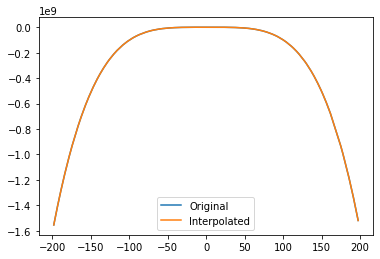

In [355]:
Check_interpolation(Original_func,interpolation_func,minimum,maximum, number_of_samples = 200)

Interpolation using Lagrange:

In [356]:
'''
Lagrange interpolation is a method for finding a polynomial that fits a set of points. Given a set of n points 
(x_1, y_1), (x_2, y_2), ..., (x_n, y_n), the Lagrange interpolation polynomial is defined as:
L(x) = ∑ y_i * l_i(x)
where l_i(x) is the ith Lagrange basis polynomial, defined as:
l_i(x) = ∏ (x - x_j) / (x_i - x_j)  for all j ≠ i
To implement Lagrange interpolation with 4 points,
you can define the 4 Lagrange basis polynomials and use them to calculate the interpolation polynomial as follows:
'''

'\nLagrange interpolation is a method for finding a polynomial that fits a set of points. Given a set of n points \n(x_1, y_1), (x_2, y_2), ..., (x_n, y_n), the Lagrange interpolation polynomial is defined as:\nL(x) = ∑ y_i * l_i(x)\nwhere l_i(x) is the ith Lagrange basis polynomial, defined as:\nl_i(x) = ∏ (x - x_j) / (x_i - x_j)  for all j ≠ i\nTo implement Lagrange interpolation with 4 points,\nyou can define the 4 Lagrange basis polynomials and use them to calculate the interpolation polynomial as follows:\n'

נבדוק למה נראה שהערכי האיקס המתקבלים אינם נכונים

In [357]:
def return_points_for_function(f: callable, a: float, b: float, n: int):
    # Next we will create 2 arrays: X values and f(X) values
    x_values = np.linspace(a, b, n)  # Split the range to n - points -> since every section is independent there is not much point for chebieshev
    y_values = [f(x) for x in x_values]  # Get the f(x) values
    points = [[x_values[i],y_values[i]] for i in range(n)]
    #points = np.array(list(zip(x_values, y_values)))  # Create n points in the form of (x,y)

    #split into group of 4 points (re-use 2 points from last group)
    def split_list(input_list, chunk_size):
        output = []
        end = 4
        diff = int(chunk_size / 2)
        while end < len(input_list):
            # Get the start and end indices for the current sublist
            start = end - chunk_size
            # Use slicing to get the sublist
            output.append(input_list[start:end])
            end += diff
        return output

    # use to create groups of 4 points
    Points = split_list(points, 4)
    if Points[-1][-1][0] != b:
      Points.append(points[-4:]) # Last group of points
    # Each function will be saved in a dictionary:
    functions_dict = {}
    # The 2 edge functions:
    functions_dict[points[1][0]] = Points[0]
    for Pi in Points:
        # The interpolation for section [xi,x_i + 4]
        functions_dict[Pi[3][0]] = Pi
    functions_dict[points[-1][0]] = Points[-1]
    # Create a function that returns an interpolation function -> for x returns f(x)

    def interpolatz_PLATZ(x):
        for key in functions_dict.keys():  # Find the spline (function) that x answers to
            if x <= key:
                y = functions_dict[key]  # Returned object is a point thus extract y-value
                return y
    return interpolatz_PLATZ


In [358]:
x = 115
get_points_for_interpolation = return_points_for_function(Original_func, minimum, maximum, 400)
#get_points_for_interpolation(x)

In [359]:
def lagrange_interpolation(points): #will 5th degree be better?
  #Rreturns a function f(x)
  def P(x):
    total = 0
    n = len(points)
    for i in range(n):
      xi, yi = points[i]
      def g(i, n):
        total = 1
        for j in range(n):
          if i == j:
            continue
          xj, yj = points[j]
          total *= (x - xj) / (xi - xj)
        return total
      total += yi * g(i, n)
    return total
  return P


In [360]:
f = lagrange_interpolation([(1,2), (2,3), (3,4), (4,5), (5,6)])
f(3.5)

4.5

In [361]:
def interpolate_v3(f: callable, a: float, b: float, n: int) -> callable:
    """
    Returns
    -------
    The interpolating function.
    """
    if n == 1:  # In case we can only use 1 point -> return a straight line
        f = lambda x: f((a + b) / 2)
        return f
    # Next we will create 2 arrays: X values and f(X) values
    x_values = np.linspace(a, b, n)  # Split the range to n - points -> since every section is independent there is not much point for chebieshev
    y_values = [f(x) for x in x_values]  # Get the f(x) values
    points = [[x_values[i],y_values[i]] for i in range(n)]
    #points = np.array(list(zip(x_values, y_values)))  # Create n points in the form of (x,y)

    #split into group of n points (re-use x2...xn points from every group)
    def split_list(input_list, chunk_size,end = b):
        output = []
        start = 0
        diff = 2
        index = start
        while start + chunk_size <= len(input_list):
          output.append(input_list[start:start + chunk_size])
          start += diff
        if output[-1][-1][0] < end:
          output.append(input_list[-chunk_size:]) # Last group of points
        return output

    # use to create groups of 7 points
    Points = split_list(points, 7)

    # Each function will be saved in a dictionary:
    # The 2 edge functions:
    functions_dict = {}
    for Pi in Points:
        # The interpolation for section [xi,x_i + 4]
        functions_dict[Pi[4][0]] = lagrange_interpolation(Pi)
    functions_dict[points[-1][0]] = lagrange_interpolation(Points[-1])
    # Create a function that returns an interpolation function -> for x returns f(x)

    def interpolatz_PLATZ(x):
        for key in functions_dict.keys():  # Find the spline (function) that x answers to
            if x <= key:
                y = functions_dict[key](x)  # Returned object is a point thus extract y-value
                return y
    # This line will hold the interpolation function as a returned parameter f(x_given) = y_value
    return interpolatz_PLATZ

In [362]:
Original_func = lambda x: x**3 - x**4
interpolation_func = interpolate_v3(Original_func, minimum, maximum, 400)

9.646502914784334e-08


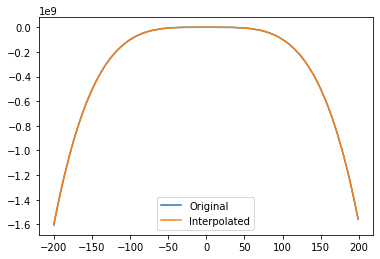

In [363]:
Check_interpolation(Original_func,interpolation_func,minimum,maximum, number_of_samples = 200)

אמאלה ואבאלה אני מפליץ פה מהתרגשות איזה פאקינג כיף
רק לוודא האם רשימת הנקודות היא רציפה

להכין בדיקת השוואה בין גרסה 1 לגרסה 3

In [364]:
# Lets create a Program that will show us the gain from the number of sections I create on different functions
#Test functions from assignment:
f0 = lambda x: x - 1
f1 = lambda x: 5
f2 = lambda x: x**2 -3*x + 5
f3 = lambda x: math.sin(x**2)
f4 = lambda x: math.e**(-2*x**2)
f5 = lambda x: math.atan(x)
f6 = lambda x: 1/math.log(x+201) 
f7 = lambda x: math.e**math.e**x #error
f8 = lambda x: math.log(math.log(x+201)) #error
f9 = lambda x: math.sin(math.log(x+201)) #error 
f21 = lambda x: (math.sin(x))/x 
f22 = lambda x: (2**(1/(x**2)))*math.sin(1/x) #error

#Other functions:
f10 = lambda x: 4* math.sin(10*x) - math.cos(x/7)*x + x + 2
f11 = lambda x: x**3
f12 = lambda x: math.sin(x)
f13 = lambda x: 5*(x**3) - 5*(x**2) -5*x -5
f14 = lambda x: 5*(x**2) - 1
f15 = lambda x: x - 1
f16 = lambda x: -2*(x**2) + 2
f17 = lambda x: 2*(x**2) - 2
f18 = lambda x: math.cos(x/309)
f19 = lambda x: x**5 - 34*x**4 +276*x**2 -987
f20 = lambda x: math.sin(x**5) + x**2 - 987
f23 = lambda x: x**3 - x**4
f24 = lambda x: x**6 - 50*x**2 +276*x**7 -98788747
f25 = lambda x: x**10 - 2*x**9 +5*x**7 -98788747*x + x**5
f26 = lambda x: 7*x**9 - 2*x**5 +5*x**10 -1298788747*x + x**6
functions = [f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23]

In [365]:
def Check_interpolation_no_graph(Original_func,interpolation_func,minimum,maximum, number_of_samples = 200):

  # Define the range of x values over which you want to plot the functions
  x_values = [random.uniform(minimum, maximum) for _ in range(number_of_samples)] # random
  x_values.remove(0) if 0 in x_values else None
  x_values = sorted(x_values)
  # Evaluate the first function over the range of x values
  y1 = [Original_func(x) for x in x_values]

  # Evaluate the second function over the range of x values
  y2 = [interpolation_func(x) for x in x_values]

  #Calaulate the error:
  def RMSE(y1,y2):
    errors = []
    for i in range(len(y1)):
      errors.append((y1[i] - y2[i])**2)
    return math.sqrt(sum(errors) / len(errors))
  return RMSE(y1,y2)

בדיקה עכשיו של פונקציה מול פונקציה באופן ידני

In [366]:
func = functions[6]
interpolation_func_v1 = interpolate_v1(func, -20, 20, 400)
interpolation_func_v3 = interpolate_v3(func, -20, 20, 400)
g1 = Check_interpolation_no_graph(func,interpolation_func_v1,-10,10, number_of_samples = 200)
g3 = Check_interpolation_no_graph(func,interpolation_func_v3,-10,10, number_of_samples = 200)
print(f'{"g1" if g1 < g3 else "g3"} is better for this func with {[g1,g3]}')


g3 is better for this func with [6.283435673255384e-17, 3.516314866869299e-17]


In [367]:
functions = [f0,f1,f2,f3,f4,f5,f6,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f23,f24,f25,f26]
index = 0
v1 = []
v3 = []
leaderboard = [0,0]
for func in functions:
  interpolation_func_v1 = interpolate_v1(func, -20, 20, 400)
  interpolation_func_v3 = interpolate_v3(func, -20, 20, 400)
  #print("hi")
  g1 = Check_interpolation_no_graph(func,interpolation_func_v1,-20,20, number_of_samples = 200)
  g3 = Check_interpolation_no_graph(func,interpolation_func_v3,-20,20, number_of_samples = 200)
  index += 1
  v1.append(g1)
  v3.append(g3)
  if g1 < g3:
    leaderboard[0] += 1
  else:
    leaderboard[1] += 1
  print(f'{"g1" if g1 < g3 else "g3"} is better for this func with {[g1,g3]}')
print(leaderboard)

g3 is better for this func with [2.58768016533827e-15, 2.022282803351199e-15]
g3 is better for this func with [1.012679207245471e-15, 9.079425345009217e-16]
g3 is better for this func with [1.4814951975613467e-06, 3.8880346367867084e-14]
g3 is better for this func with [0.4124962553788487, 0.37749555552025493]
g3 is better for this func with [7.927960512629125e-07, 1.5311759899183895e-07]
g3 is better for this func with [6.18874020808439e-08, 1.1715826620190742e-08]
g3 is better for this func with [4.095973014617851e-11, 3.865904340312231e-17]
g3 is better for this func with [0.011131579542746562, 0.004146102398782199]
g3 is better for this func with [0.003006574126008401, 4.441993450558501e-13]
g3 is better for this func with [3.167612346632025e-05, 1.2927599322220974e-10]
g3 is better for this func with [0.0018057926779877203, 3.4975888002672375e-12]
g3 is better for this func with [0.0002721073362685349, 2.025749026652686e-13]
g3 is better for this func with [2.792751619271632e-15, 

נבדוק את פונקציית חלוקת הנקודות על מנת לוודא שמקבלים קטע רציף

In [368]:
# Next we will create 2 arrays: X values and f(X) values
n = 37
x_values = np.linspace(-20, 20, n)  # Split the range to n - points -> since every section is independent there is not much point for chebieshev
y_values = [func(x) for x in x_values]  # Get the f(x) values
points = [[x_values[i],y_values[i]] for i in range(n)]
b = 20
#split into group of n points (re-use x2...xn points from every group)
def split_list(input_list, chunk_size,end = b):
    output = []
    start = 0
    diff = 2
    index = start
    while start + chunk_size <= len(input_list):
      output.append(input_list[start:start + chunk_size])
      start += diff
    if output[-1][-1][0] < end:
      output.append(input_list[-chunk_size:]) # Last group of points
    return output

# use to create groups of 7 points
Points = split_list(points, 7)

In [369]:
l = True
for i in Points[:len(Points)-2]:
  if len(i) != 7:
    l = False
l

True

בדיקה על פונקציות רנדומאליות כמו רמי ממעלה 30

In [399]:
a = np.random.randn(30)
f = np.poly1d(a)
ff = interpolate_v1(f, -10, 10, 100)
fff = interpolate_v3(f, -10, 10, 100)
g1 = Check_interpolation_no_graph(f,ff,-10,10, number_of_samples = 100)
g3 = Check_interpolation_no_graph(f,fff,-10,10, number_of_samples = 100)
print(f'{"g1" if g1 < g3 else "g3"} is better for this func with {[g1,g3]}')

g3 is better for this func with [9.897442325946637e+24, 1.0824726140563883e+22]
